In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import altair as alt

In [2]:
# build a co-authorship graph

# add a node for each author, and an edge for each co-authorship (i.e., if they are in the same row, they are co-authors)
# the weight of the edge is the number of times they have co-authored a paper

# read the data
data = pd.read_csv('dblp_graph_conference.csv')

# create a graph
G = nx.Graph()

# add nodes (author_id) and nodes attributes (author_name, author_org)
author_data = {}

for i in range(len(data)):
    author_ids = data['author_id'][i].split(';')
    author_names = data['author_name'][i].split(';')
    author_orgs = str(data['author_org'][i]).split(';')
    n_citations = data['n_citation'][i] if not np.isnan(data['n_citation'][i]) else 0

    for j, author_id in enumerate(author_ids):
        # Only add unique authors to the dictionary
        if author_id not in author_data:
            author_data[author_id] = {
                'name': author_names[j] if j < len(author_names) else np.nan,
                'org': author_orgs[j] if j < len(author_orgs) else np.nan,
                'total_citations': 0,
                'total_papers': 0
            }
        author_data[author_id]['total_citations'] += n_citations
        author_data[author_id]['total_papers'] += 1

# Add nodes with attributes to the graph
for author_id, attributes in author_data.items():
    G.add_node(author_id, name=attributes['name'], org=attributes['org'], total_citations=attributes['total_citations'], total_papers=attributes['total_papers'])

In [3]:
# randomly select 10 nodes and print their attributes
nodes = np.random.choice(list(G.nodes()), 10)
for node in nodes:
    print(f"Node {node}: {G.nodes[node]}")

Node 2157773569: {'name': 'Koichi Yamazaki', 'org': 'Gunma University', 'total_citations': 1, 'total_papers': 1}
Node 2338658193: {'name': 'Shaheena Sultana', 'org': 'Bangladesh University of Engineering and Technology (BUET)', 'total_citations': 1, 'total_papers': 1}
Node 2145510349: {'name': 'Shinichi Tamura', 'org': 'nan', 'total_citations': 12, 'total_papers': 1}
Node 2171566200: {'name': 'Hanchen Song', 'org': 'Coll. of Inf. Syst. & Manage., Nat. Univ. of Defense Technol., Changsha, China', 'total_citations': 0, 'total_papers': 1}
Node 1979157086: {'name': 'Jing Hua', 'org': 'Wayne State University, Detroit, MI, USA', 'total_citations': 53, 'total_papers': 1}
Node 94155302: {'name': 'Sylvain Meignier', 'org': 'LIUM, University of Maine', 'total_citations': 3, 'total_papers': 1}
Node 716715026: {'name': 'Joe Halpern', 'org': 'nan', 'total_citations': 10, 'total_papers': 1}
Node 2121268267: {'name': 'Kyungmoo Lee', 'org': 'Departments of Electrical and Computer Engineering, and The 

In [4]:
# add edges
for i in range(len(data)):
    authors = data['author_id'][i].split(';')
    for author1 in authors:
        for author2 in authors:
            if author1 != author2:
                if G.has_edge(author1, author2):
                    G[author1][author2]['weight'] += 1
                else:
                    G.add_edge(author1, author2, weight=1)

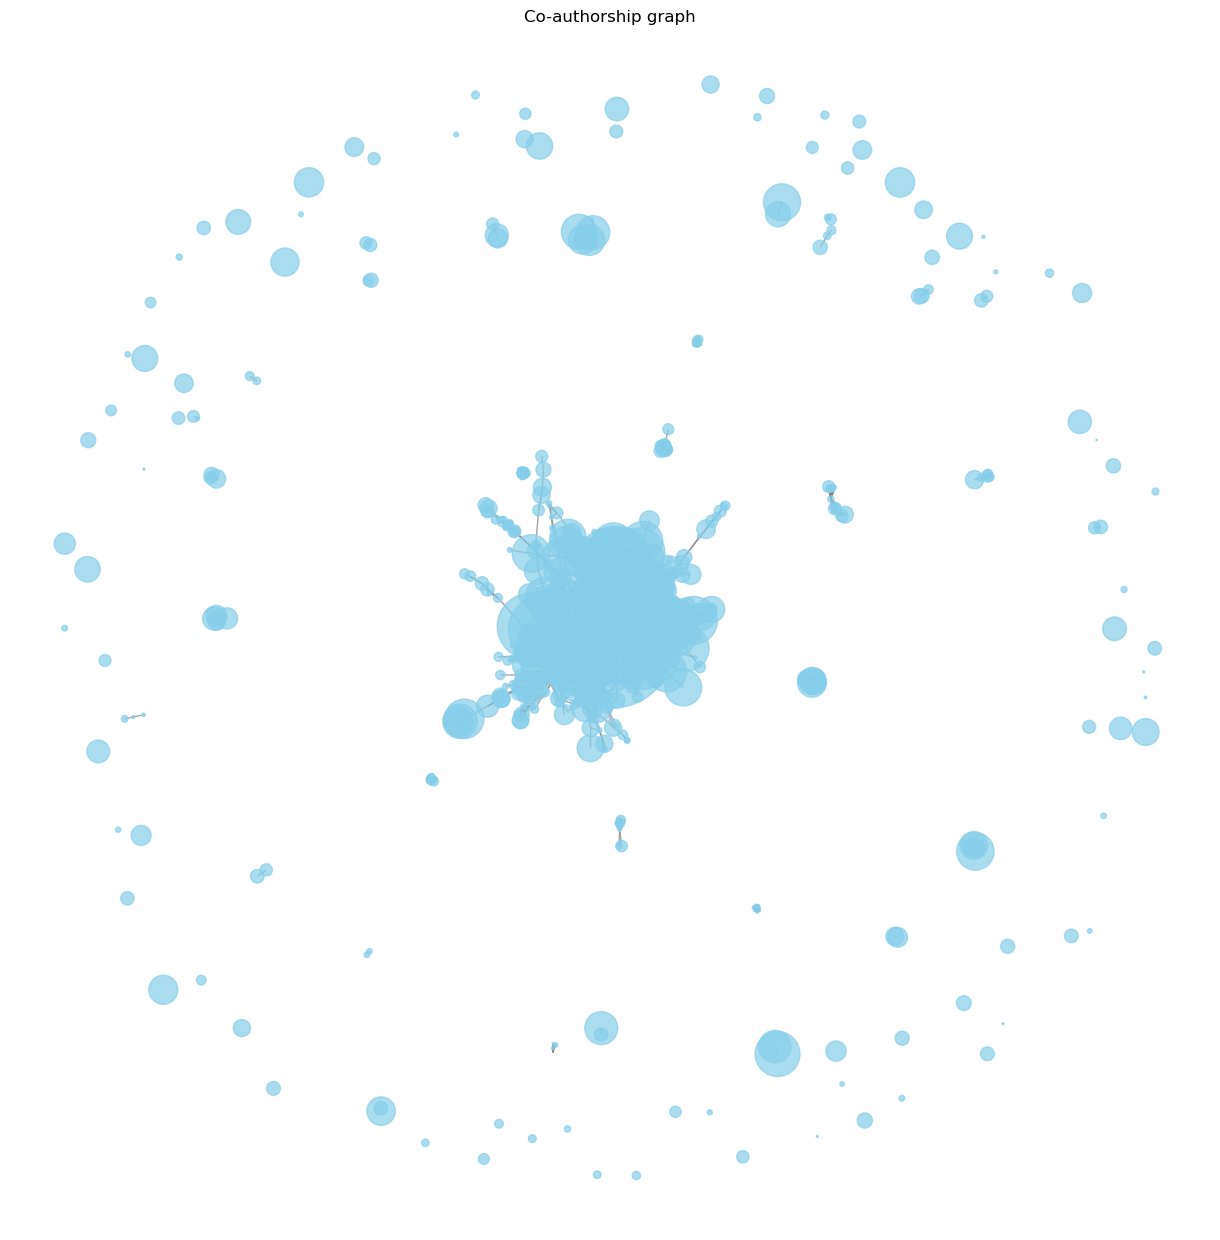

In [5]:
# draw the graph, but only the top 1000 authors
top_authors = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[:1000]
G_top = G.subgraph(top_authors)

node_sizes = [G_top.nodes[author]["total_citations"] for author in G_top.nodes]
pos = nx.spring_layout(G_top)

plt.figure(figsize=(12, 12))
nx.draw(G_top, pos, node_size=node_sizes, with_labels=False, node_color='skyblue', edge_color='gray',alpha=0.7)
plt.title('Co-authorship graph')
plt.show()

In [6]:
nodes_df = pd.DataFrame({
    'author_id': list(G_top.nodes),
    'x': [pos[author][0] for author in G_top.nodes],
    'y': [pos[author][1] for author in G_top.nodes],
    'name': [G_top.nodes[author]["name"] for author in G_top.nodes],
    'org': [G_top.nodes[author]["org"] for author in G_top.nodes],
    'total_citations': [G_top.nodes[author]["total_citations"] for author in G_top.nodes],
    'total_papers': [G_top.nodes[author]["total_papers"] for author in G_top.nodes]
})

# Altair chart for interactive and zoomable visualization
alt_chart = alt.Chart(nodes_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    size=alt.Size('total_citations:Q', scale=alt.Scale(range=[10, 500]), legend=None),
    color=alt.Color('total_papers:Q', scale=alt.Scale(scheme='blueorange')),
    tooltip=['name:N', 'org:N', 'total_citations:Q', 'total_papers:Q']
).interactive()  # This makes the chart zoomable and pannable

# Display Altair chart
alt_chart

/opt/miniconda3/envs/si608/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/miniconda3/envs/si608/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/miniconda3/envs/si608/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [7]:
# Calculate the average number of papers and citations per author
total_papers = sum([G.nodes[author]["total_papers"] for author in G.nodes])
total_citations = sum([G.nodes[author]["total_citations"] for author in G.nodes])
average_papers_per_author = total_papers / len(G.nodes)
average_citations_per_author = total_citations / len(G.nodes)

print(f"Average number of papers per author: {average_papers_per_author}, Average number of citations per author: {average_citations_per_author}")

Average number of papers per author: 1.53156039123512, Average number of citations per author: 21.581564182273105


In [9]:
# Calculate the proportion of largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest_cc = G.subgraph(largest_cc)
largest_cc_proportion = len(largest_cc) / len(G.nodes)

print(f"Proportion of largest connected component: {largest_cc_proportion}")

Proportion of largest connected component: 0.3623095003411934


In [10]:
# Calculate the average clustering coefficient
average_clustering_coefficient = nx.average_clustering(G)
print(f"Average clustering coefficient: {average_clustering_coefficient}")

Average clustering coefficient: 0.7280615814494653


In [11]:
# Calculate the average shortest path length for the largest connected component
# but nx.average_shortest_path_length has the complexity of O(V^3)


# average_shortest_path_length = nx.average_shortest_path_length(G_largest_cc)
# print(f"Average shortest path length for the largest connected component: {average_shortest_path_length}")

KeyboardInterrupt: 

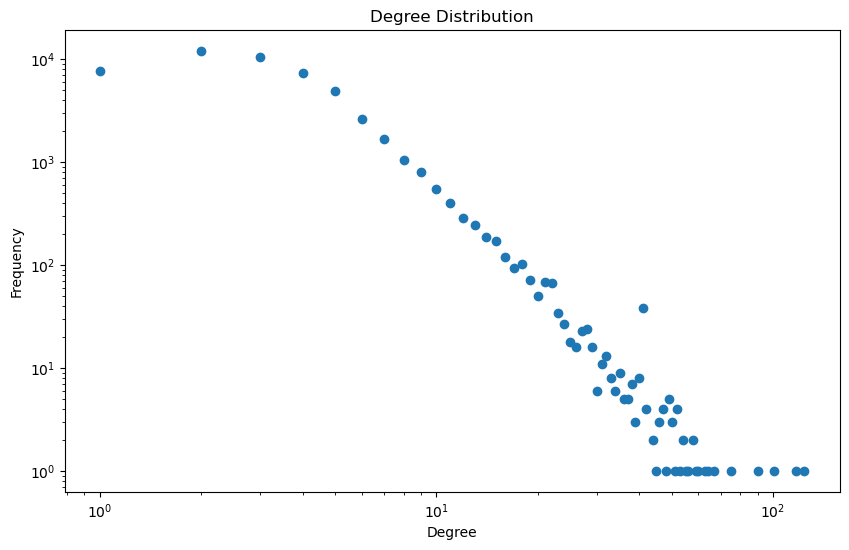

In [12]:
# Calculate the degree distribution
degree_distribution = nx.degree_histogram(G)
degrees = range(len(degree_distribution))
plt.figure(figsize=(10, 6))
plt.loglog(degrees, degree_distribution, 'o')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [13]:
# Calculate the degree centrality
degree_centrality = nx.degree_centrality(G)
max_degree_centrality_author = max(degree_centrality, key=degree_centrality.get)
max_degree_centrality_value = degree_centrality[max_degree_centrality_author]
print(f"Author with the highest degree centrality: {max_degree_centrality_author}, Degree centrality value: {max_degree_centrality_value}")

Author with the highest degree centrality: 2198983026, Degree centrality value: 0.0023504881053928537


In [15]:
# Community detection using Louvain algorithm
communities = nx.algorithms.community.greedy_modularity_communities(G)
community_dict = {}
for i, community in enumerate(communities):
    for author in community:
        community_dict[author] = i

nodes_df['community'] = [community_dict[author] for author in nodes_df['author_id']]
alt_chart_community = alt.Chart(nodes_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='community:N',
    tooltip=['name:N', 'org:N', 'total_citations:Q', 'total_papers:Q']
).interactive()

# Display Altair chart with community colors
alt_chart_community

/opt/miniconda3/envs/si608/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/miniconda3/envs/si608/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/miniconda3/envs/si608/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)